# 1. Logistic Regression

## 1.1. Chuẩn bị

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### Phân phối Logistic
Phân phối logistic là phân phối có hình dạng *chuông* gần giống với phân phối chuẩn. Phân phối logistic có PDF (probability density function - hàm mật độ xác suất) theo 2 tham số là $\mu$ (location) và $s$ (scale) là: $\mathbf{x}\sim\text{Logistic}(\mathbf{x};\mu,s)$ và CDF (cumulative distribution function - hàm phân phối tích luỹ) là:

$$F(\mathbf{x};\mu,s) = \frac{1}{1+\exp\left(-\frac{\mathbf{x}-\mu}{s}\right)}$$

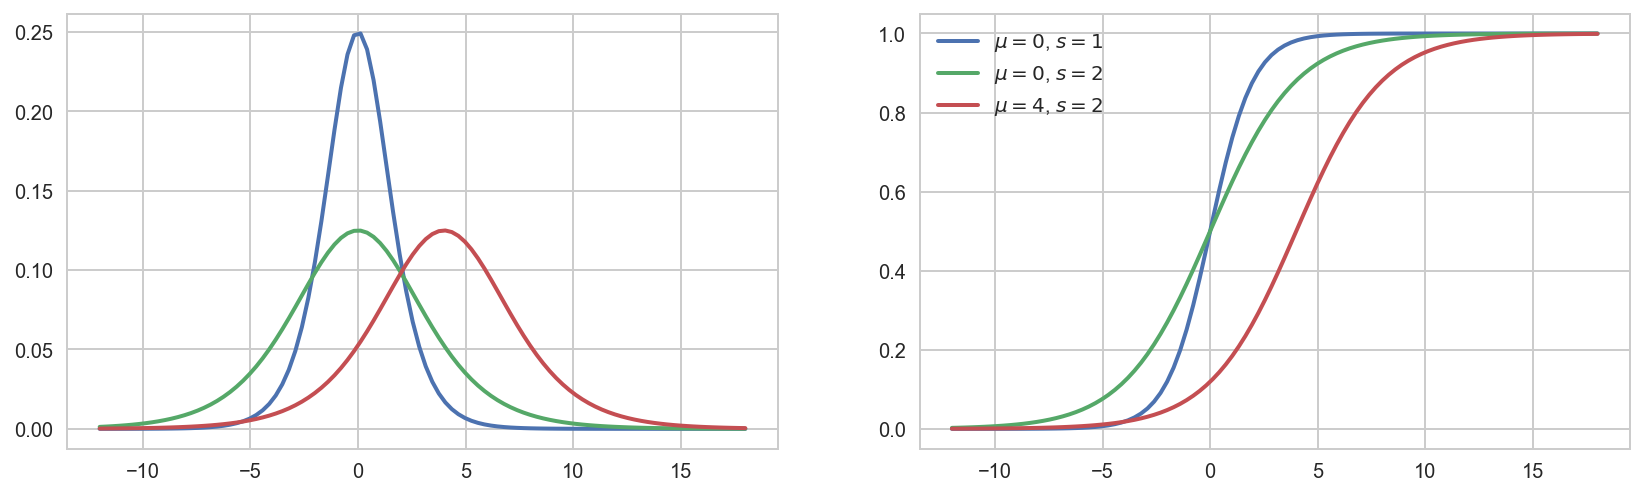

In [23]:
data = [(0, 1), (0, 2), (4, 2)]
fig, ax = plt.subplots(ncols=2, figsize=(14,4))
for mu, s in data:
    x = np.linspace(-12, 18, 100)
    y1 = stats.logistic(mu, s).pdf(x)
    y2 = stats.logistic(mu, s).cdf(x)
    ax[0].plot(x, y1, linewidth=2)
    ax[1].plot(x, y2, linewidth=2)
ax[1].legend([fr'$\mu={mu}$, $s={s}$' for mu, s in data])
plt.show()

### Probability
Nhắc lại về probability của biến ngẫu nhiên $\mathbf{x}$:
- Trường hợp $\mathbf{x}$ là biến rời rạc: probability là xác suất $\mathbf{x}$ nhận một giá trị cụ thể khi đã biết tham số của phân phối. VD: nếu $\mathbf{x}$ là số lần thu được mặt ngửa khi tung đồng xu $n$ lần thì $\mathbf{x}$ tuân theo [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution): $\mathbf{x}\sim\text{Bin}(n,p)$. Muốn tính xác suất thu được 5 mặt ngửa sau 7 lần tung đồng xu, ta thay $\mathbf{x}=5,n=7,p=0.5$ vào hàm PMF của binomial distribution:

$$P(\mathbf{x}=5\,|\,n,p)=f(\mathbf{x}=5;n,p)$$

- Trường hợp $\mathbf{x}$ là biến liên tục: probability là xác suất của $\mathbf{x}$ nằm trong một khoảng giá trị. Khác với biến rời rạc, nếu một biến liên tục nhận một giá trị cụ thể thì xác suất đó bằng 0. VD: của một nhóm người có chiều cao trung bình là 170 cm và độ lệch chuẩn là 5 cm. Trên thực tế chiều cao con người thường tuân theo phân phối chuẩn, như vậy đại lượng chiều cao là một biến $\mathbf{x}\sim\text{N}(\mu=170,\sigma=5)$. Xác suất một người bất kỳ có chiều cao từ 172 đến 176 cm là:

$$P(172<\mathbf{x}<176\,|\,\mu,\sigma)=F(\mathbf{x}=176;\mu,\sigma)-F(\mathbf{x}=172;\mu,\sigma)$$

Ký hiệu $f$ là PDF (với biến liên tục) hoặc PMF (với biến rời rạc) và $F$ là hàm CDF (với cả hai trường hợp).

In [46]:
# initialize the distribution
mu, sigma = 170, 5
dist = stats.norm(mu, sigma)

# left and right bounds or integral limits
a, b = 172, 176

In [47]:
# probability using CDF
np.abs(dist.cdf(a) - dist.cdf(b))

0.2295085881679676

In [49]:
# probability using PDF
nBin = 1000
sizeBin = (b - a) / nBin
(dist.pdf(np.linspace(a, b, nBin)) * sizeBin).sum()

0.22950405748186037

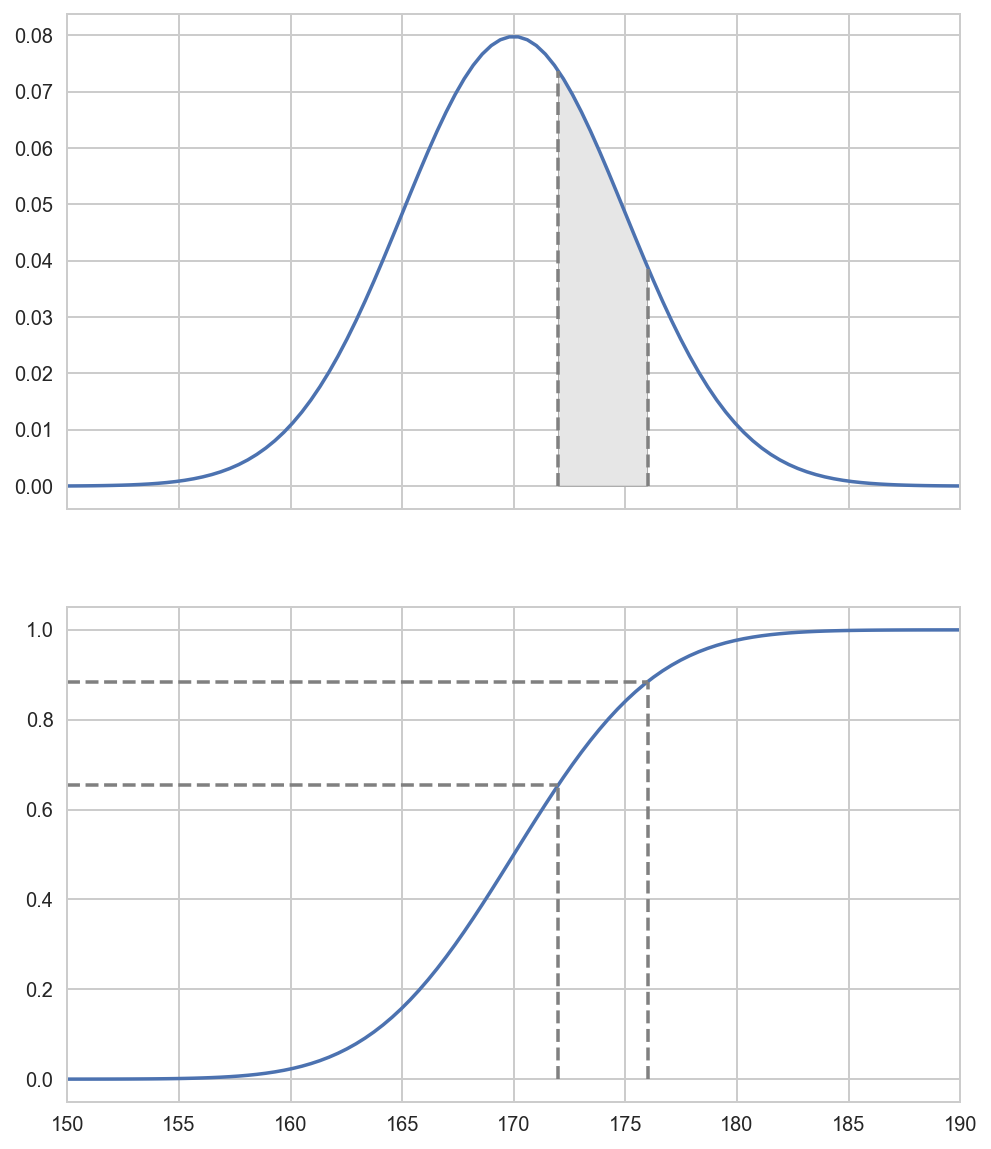

In [44]:
from matplotlib.patches import Polygon

# x limits
xLeft, xRight = 150, 190

x = np.linspace(xLeft, xRight, 100)
y1 = dist.pdf(x)
y2 = dist.cdf(x)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
ax1.set_xlim(xLeft, xRight)

ax1.plot(x, y1)
ax1.plot([a, a], [0, dist.pdf(a)], c='grey', ls='--')
ax1.plot([b, b], [0, dist.pdf(b)], c='grey', ls='--')

# area under the curve
ix = np.linspace(a, b)
iy = dist.pdf(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax1.add_patch(poly)

ax2.plot(x, y2)
ax2.plot([a, a], [0, dist.cdf(a)], c='grey', ls='--')
ax2.plot([b, b], [0, dist.cdf(b)], c='grey', ls='--')
ax2.plot([xLeft, a], [dist.cdf(a), dist.cdf(a)], c='grey', ls='--')
ax2.plot([xLeft, b], [dist.cdf(b), dist.cdf(b)], c='grey', ls='--')

plt.show()

### Likelihood
Khác với probability, likelihood là đại lượng thể hiện khả năng tìm được bộ tham số phân phối phù hợp với bộ dữ liệu đã quan sát được. Cụ thể, probability sẽ trả lời câu hỏi: *"Nếu $\mathbf{x}$ là dữ liệu chiều cao một nhóm người tuân theo phân phối chuẩn với bộ tham số đã biết là $\mu=170$ và $\sigma=5$ thì xác suất một người bất kỳ cao từ 172 - 176 cm là bao nhiêu?"*. Trong khi đó, likelihood sẽ trả lời câu hỏi: *"Nếu đã biết chiều cao của một người trong nhóm là 165 cm, thì likelihood để $\mu=170$ và $\sigma=5$ là bao nhiêu?"*. Likelihood trong trường hợp này là:

$$L(\mu=170,\sigma=5\,|\,\mathbf{x}=165)=f(\mathbf{x}=165;\mu=170,\sigma=5)$$

Chú ý rằng likelihood luôn dương và có thể lớn hơn 1 (khác với probability chỉ nằm trong khoảng 0 đến 1). Likelihood cũng có tính chất nhân, giống probability:

$$L(\mu,\sigma\,|\,\mathbf{x})=\prod_{n=1}^{N} L(\mu,\sigma\,|\,x_n)$$

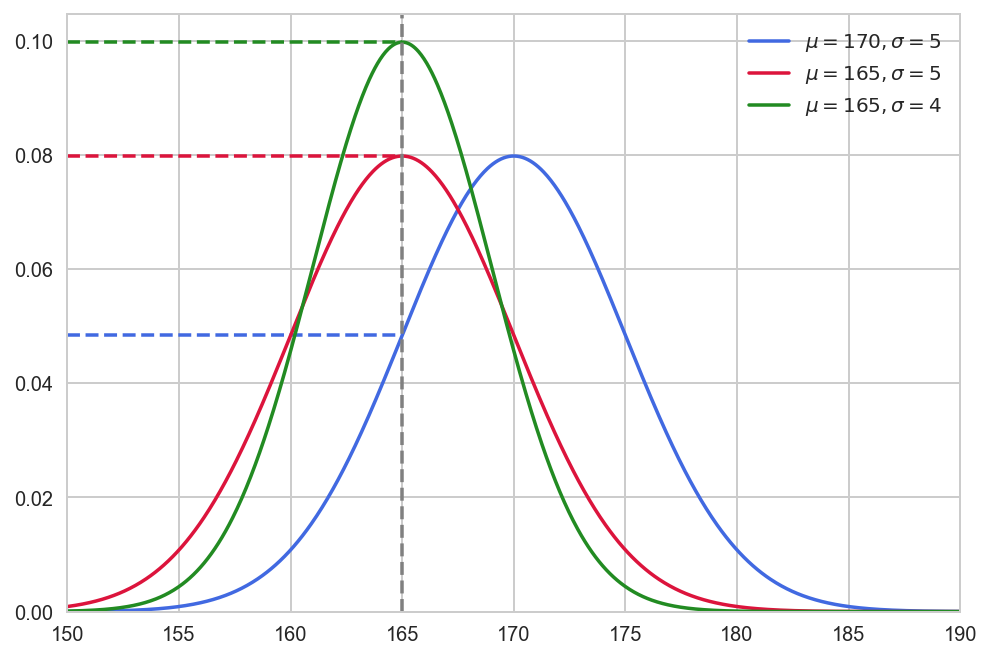

In [39]:
params = [
    (170, 5, 'royalblue'),
    (165, 5, 'crimson'),
    (165, 4, 'forestgreen')
]

xSample = 165

xLeft, xRight = 150, 190
yBot = 0
x = np.linspace(xLeft, xRight, 1000)

fig, ax = plt.subplots()
for mu, sigma, color in params:
    dist = stats.norm(mu, sigma)
    y = dist.pdf(x)
    ax.plot(x, y, c=color, label=f'$\mu={mu},\sigma={sigma}$')
    ax.plot([xLeft, xSample], [dist.pdf(xSample), dist.pdf(xSample)], c=color, ls='--')
ax.axvline(xSample, c='grey', ls='--')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(xLeft, xRight)
plt.show()

### Maximum likelihood estimation
MLE là phương pháp ước lượng giá trị cho bộ tham số của phân phối sao cho likelihood đạt giá trị lớn nhất, khi đó phân phối thu được sẽ mô tả sát thực nhất các điểm dữ liệu quan sát được. Giả sử có thể quan sát được chiều cao của 3 người là 168, 170 và 175 cm, khi này câu hỏi là *"Đâu là bộ tham số của phân phối chuẩn mô tả chính xác nhất bộ dữ liệu trên?"*. Ta sẽ cần tìm $\mu$ và $\sigma$ sao cho likelihood đạt max như sau:

$$L(\mu,\sigma\,|\,\mathbf{x})=\prod_{n=1}^{N}f(x_n;\mu,\sigma)$$

Việc tìm ra giá trị $\mu$ và $\sigma$ sao cho $L$ đạt max, có thể thực hiện bằng cách giải phương trình đạo hàm bằng 0. Tuy nhiên việc tính toán đạo hàm của hàm nhân rất phức tạp, vì vậy ta sẽ đạo hàm gián tiếp thông qua hàm log, từ đó dẫn đến tên gọi rất phổ biến: log-likelihood.

$$\log(L(\mu,\sigma\,|\,\mathbf{x})=\sum_{n=1}^{N}\log(f(x_n;\mu,\sigma))$$

## 1.2. Thuật toán

Thuật toán [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) chỉ khác linear regression đó là biến đầu ra $\mathbf{y}$ thay vì là giá trị liên tục thì chỉ nhận 1 trong 2 giá trị 0 (negative) hoặc 1 (positive). Vì vậy hồi quy logistic được sử dụng trong bài toán phân lớp. Chính xác hơn, đầu ra của thuật toán là giá trị nằm trong khoảng $[0,1]$ - là xác suất rơi vào nhóm positive của các quan sát. Hàm hồi quy sẽ có dạng:

$$\mathbf{p} = \frac{1}{1+e^{-(w_0+w_1\mathbf{x}_1+w_2\mathbf{x}_2+\dots)}}$$

Trong đó:
- $\mathbf{y}=y_1,y_2,\dots,y_N$ là biến đầu ra
- $\mathbf{p}=p_1,p_2,\dots,p_N$ với $p_n=P(y_n=1|\mathbf{x}_n;\mathbf{w})$ là xác suất để $y_n=1$
- $\mathbf{x}_1,\mathbf{x}_2,\dots$ là các biến đầu vào
- $w_0,w_1,w_2,\dots$ là hệ số của hàm hồi quy

Một cách viết khác của hàm hồi quy là tỷ số odds (tỷ lệ success so với failed) cũng hay được sử dụng. Đây chính là dạng tuyến tính của mô hình hồi quy logistic:

$$\ln(\frac{\mathbf{p}}{1-\mathbf{p}}) = w_0+w_1\mathbf{x}_1+w_2\mathbf{x}_2+\dots$$

Công thức tổng quát của hàm hồi quy có dạng: $\mathbf{p}=f(\mathbf{X}\mathbf{w})$, với $f$ là hàm sigmoid (một trường hợp đặc biệt của hàm logistic):

$$f(x)=\frac{1}{1+e^{-x}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

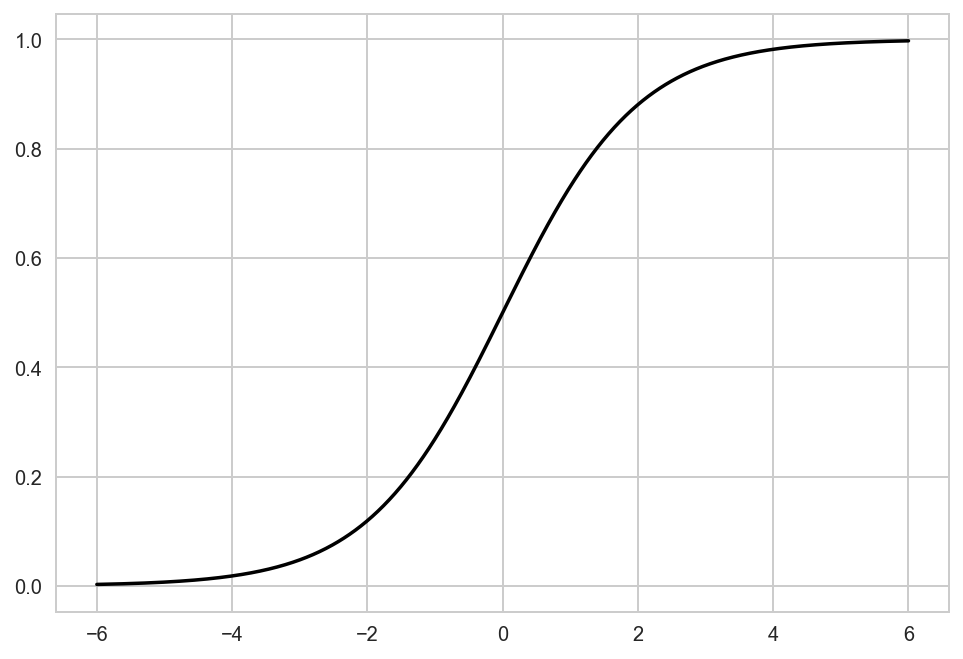

In [5]:
x = np.linspace(-6, 6, 1000)
y = 1 / (1 + np.e**(-x))

fig, ax = plt.subplots()
ax.plot(x, y, 'k')
plt.show()

### Hàm mất mát

Dễ thấy $P(\mathbf{y}=1)=f(\mathbf{X}\mathbf{w})$ và $P(\mathbf{y}=0)=1-f(\mathbf{X}\mathbf{w})$, như vậy $\mathbf{y}$ tuân theo phân phối [Bernourlli](https://en.wikipedia.org/wiki/Bernoulli_distribution) với tham số $\mathbf{p}=f(\mathbf{X}\mathbf{w})$ chưa biết. Nhiệm vụ của bài toán là tìm $\mathbf{p}$ hay cụ thể hơn là tìm $\mathbf{w}$ sao cho tối đa hoá likelihood của phân phối Bernoulli dựa vào các giá trị $\mathbf{y}$ đã quan sát được. Nếu likelihood lớn, đồng nghĩa với việc $\mathbf{w}$ *thành công* trong việc mô hình hoá phân phối thực tế của $\mathbf{y}$. Biểu thức tính likelihood được xây dựng như sau:

$$P(\mathbf{y}\,|\,\mathbf{p}) = \mathbf{p}^\mathbf{y}(1-\mathbf{p})^{1-\mathbf{y}} = \prod_{n=1}^{N}{p_n^{y_n}(1-p_n)^{1-y_n}}$$

Như đã phân tích ở phần MLE, để cực đại hoá likelihood ta sẽ giải gián tiếp thông qua log-likelihood. Likelihood hay log-likelihood trong trường hợp này có thể coi là một dạng reward function. Nhưng để có sự đồng điệu với các thuật toán khác, ta sẽ chọn negative log-likelihood là loss function.

$$L(\mathbf{w}) = -\log P(\mathbf{y}|\mathbf{X}) = \sum{\left[y_i\log{p_i}+(1-y_i)\log{(1-p_i)}\right]}$$

Vector hệ số $\mathbf{w}$ thỏa mãn: $\hat{\mathbf{w}} =\arg\min L(\mathbf{w})$.

In [44]:
def CrossEntropy(y, yHat):
    if y == 1:
        return -np.log(yHat)
    else:
        return -np.log(1 - yHat)

In [45]:
CrossEntropy(1, 0.9)

0.10536051565782628

In [46]:
CrossEntropy(1, 0.1)

2.3025850929940455

## 1.2. Implementation
[Logistic Regression implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) không có siêu tham số

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
credit = pd.read_csv('data/credit_scoring.csv')
credit = credit.dropna().reset_index()
credit.head()

,index,bad_customer,credit_balance_percent,age,num_of_group1_pastdue,debt_ratio,income,num_of_loans,num_of_times_late_90days,num_of_estate_loans,num_of_group2_pastdue,num_of_dependents
0,0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
y = credit.bad_customer.values
X = credit.drop(columns='bad_customer')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
logistic = LogisticRegression().fit(X_train, y_train)

In [6]:
y_train_pred = logistic.predict(X_train)
y_test_pred = logistic.predict(X_test)
y_test_prob_pred = logistic.predict_proba(X_test)

In [9]:
prob = pd.DataFrame(y_test_prob_pred)
prob = prob.assign(class_=y_test_pred)
prob

,0,1,class_
0,0.962505,0.037495,0
1,0.974465,0.025535,0
2,0.954811,0.045189,0
3,0.930182,0.069818,0
4,0.949860,0.050140,0
...,...,...,...
24049,0.952834,0.047166,0
24050,0.911643,0.088357,0
24051,0.962586,0.037414,0
24052,0.963384,0.036616,0


In [42]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     89539
           1       0.58      0.04      0.08      6676

    accuracy                           0.93     96215
   macro avg       0.76      0.52      0.52     96215
weighted avg       0.91      0.93      0.90     96215



In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22373
           1       0.53      0.04      0.08      1681

    accuracy                           0.93     24054
   macro avg       0.73      0.52      0.52     24054
weighted avg       0.90      0.93      0.90     24054



# 2. Naive Bayes

## 2.1. Định lý Bayes

Định lý bayes được sử dụng để tìm xác suất có điều kiện của event A khi chúng ta biết các sự kiện có liên quan. Giả sử 
$P(A)>0$ và ${B_1, B_2,\dots,B_n}$ là một tập hợp các sự kiện hoàn chỉnh. Với $k=1,2,\dots,n$ ta có:

$$P(B_k|A) = \frac{P(A|B_k)\cdot P(B_k)}{P(B_1)P(A|B_1)+P(B_2)\cdot P(A|B_2)+\dots+P(B_n)\cdot P(A|B_n)}$$

- $P(B_k|A)$ là xác suất có điều kiện: Xác suất của sự kiện $B_k$ xảy ra với điều kiện $A$ đã xảy ra. Đây còn được gọi là posterior probability của $B_k$ với $A$ cho trước.
- $P(A|B_k)$ cũng là xác suất có điều kiện: Xác suất của sự kiện $A$ xảy ra với điều kiện $B_k$ xảy ra 
- $P(A)$ và $P(B_k)$  là xác suất của các quan sát $A$ và $B_k$ khi độc lập hoàn toàn, còn được gọi là marginal probability hay prior probability.

## 2.2. Thuật toán
[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) là thuật toán dựa trên định lý bayes [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). Với bài toán phân loại, ta có tập hợp các biến đầu vào là $\mathbf{X}=\mathbf{x}_1,\mathbf{x}_2,\dots$ và $\mathbf{y}$ là biến đầu ra, định lý bayes được viết tổng quát là: 

$$P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})}$$

- $P(\mathbf{y}|\mathbf{X})$ is the posterior probability, the probability of a class for given predictors
- $P(\mathbf{X}|\mathbf{y})$ is the likelihood, the probability of predictors for a given class
- $P(\mathbf{y})$ is the prior probability of a class
- $P(\mathbf{X})$ is the prior probability of predictors

Công thức dưới đây mô tả cách thuật toán phân loại các quan sát vào các lớp $c$:

$$\hat{\mathbf{y}} = \arg\max P(\mathbf{y}=c|\mathbf{X}) =
\arg\max P(\mathbf{X}|\mathbf{y}=c)P(\mathbf{y}=c)$$

### Ước lượng giá trị likelihood
Naive Bayes assumes that $\mathbf{x}_1,\mathbf{x}_2,\dots$ are independent of each other. This assumption looks quite unrealistic, explains why the algorithm is considered naive. However, Naive Bayes performs surprisingly well in real-world classification problems. The likelihood can be written under this assumption:

$$P(\mathbf{x}_1,\mathbf{x}_2,\dots|\mathbf{y}) = \prod{P(\mathbf{x}_i|\mathbf{y})}$$

To estimate $P(\mathbf{x}_i|\mathbf{y})$, there are three distributions can be used, depending on the input data:
- Gaussian distribution, used when the input data is continuous. The parameters $\mu_{\mathbf{y}}$ and $\sigma_{\mathbf{y}}$ are estimated using maximum likelihood.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathbf{y}}}} \exp\left(-\frac{(\mathbf{x}_i - \mu_{\mathbf{y}})^2}{2\sigma^2_{\mathbf{y}}}\right)$$

- Multinomial distribution, used when the input data is categorical data. Widely used in text classification. In this formula, $N$ represents the number of observations, $\alpha$ represents the Laplace smooth coefficient, $d$ is the number of words. $\alpha=1$ is usually chosen, prevents the probability to be 0.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{N(\mathbf{x}_i|\mathbf{y})+\alpha}{N(\mathbf{y})+\alpha d}$$

- Bernoulli distribution, used for binary input data.

$$P(\mathbf{x}_i|\mathbf{y}) = p_i^{\mathbf{x}_i}(1-p_i)^{1-\mathbf{x}_i}$$

## 2.2. Implementation

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

### Tabular data
This section uses the Iris data, where input variables are continuous. For a mixed types dataset, we use `GaussianNB` for continuous input and `MultinomialNB` for categorical input, then multiply the predicted probability of each class.

In [21]:
iris = load_iris()
X = iris.data
y = iris.target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [23]:
bayes = GaussianNB()
bayes = bayes.fit(X_train, y_train)

In [24]:
y_train_pred = bayes.predict(X_train)
y_test_pred = bayes.predict(X_test)

In [25]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.94      0.91      0.92        32
           2       0.92      0.95      0.93        37

    accuracy                           0.95       105
   macro avg       0.95      0.95      0.95       105
weighted avg       0.95      0.95      0.95       105



In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.89      0.91        18
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



### Text data
Text data is preprocessed so that each column represents a word, each row represents a graph. This table shows how many times a word occurs in a graph. Then apply `MultinomialNB`.

In [27]:
X_train = np.array([
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 3, 0, 1, 2, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 2, 1, 1]
])
y_train = np.array(['A', 'A', 'A', 'B'])

X_test = np.array([
    [1, 2, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 1]
])

In [28]:
bayes = MultinomialNB()
bayes = bayes.fit(X_train, y_train)

In [29]:
bayes.predict(X_test)

array(['A', 'B'], dtype='<U1')

In [30]:
bayes.predict_proba(X_test)

array([[0.93708063, 0.06291937],
       [0.34255957, 0.65744043]])